In [1]:
# Ensemble Variant 1: S: ResNet152d, W: Densenet201
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran import CTranEncoder
torch.cuda.empty_cache()

# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA GeForce RTX 2080 Ti


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 224
num_workers = 4
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

224
224


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = 960)
model1 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = 960)
model2 = CTranEncoder(num_classes=num_classes, embed_dim=960, num_layers=6, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0]
a,b = 0.52,0.48

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels,0)
            
        with torch.no_grad():
            metric2.update(outputs2, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    del images
    del labels
    del outputs1
    del outputs2
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric1.update(weighted_outputs, labels,1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            torch.save(model1, 'models2/strongdn_rn1.pth')
            torch.save(model2, 'models2/strongdn_dn1.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric1.reset()
        del images
        del labels
        del outputs1
        del outputs2
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/200
----------


100%|██████████| 111/111 [06:44<00:00,  3.64s/it]


DenseNet201:
 Epoch [1/200], Loss: 0.2787, ML mAP: 0.1290, ML F1: 0.0209, ML AUC: 0.6238, ML Score: 0.3764, Bin AUC: 0.3889, Model Score: 0.3826, Bin F1: 0.2000
ResNet152d:
 Epoch [1/200], Loss: 0.2787, ML mAP: 0.1290, ML F1: 0.0209, ML AUC: 0.6238, ML Score: 0.3764, Bin AUC: 0.3889, Model Score: 0.3826, Bin F1: 0.2000


100%|██████████| 28/28 [01:06<00:00,  2.38s/it]


Val - Epoch [1/200], Loss: 0.2428, ML mAP: 0.3625, ML F1: 0.1070, ML AUC: 0.8575, ML Score: 0.6100, Bin AUC: 1.0000, Model Score: 0.8050, Bin F1: 0.0000

Epoch 2/200
----------


100%|██████████| 111/111 [05:12<00:00,  2.81s/it]


DenseNet201:
 Epoch [2/200], Loss: 0.3313, ML mAP: 0.2712, ML F1: 0.1156, ML AUC: 0.7877, ML Score: 0.5294, Bin AUC: 0.7500, Model Score: 0.6397, Bin F1: 0.0000
ResNet152d:
 Epoch [2/200], Loss: 0.3313, ML mAP: 0.2712, ML F1: 0.1156, ML AUC: 0.7877, ML Score: 0.5294, Bin AUC: 0.7500, Model Score: 0.6397, Bin F1: 0.0000


100%|██████████| 28/28 [00:54<00:00,  1.94s/it]


Val - Epoch [2/200], Loss: 0.2231, ML mAP: 0.4872, ML F1: 0.2442, ML AUC: 0.9009, ML Score: 0.6940, Bin AUC: 0.7368, Model Score: 0.7154, Bin F1: 0.0000

Epoch 3/200
----------


100%|██████████| 111/111 [07:49<00:00,  4.23s/it]


DenseNet201:
 Epoch [3/200], Loss: 0.2759, ML mAP: 0.4181, ML F1: 0.2771, ML AUC: 0.8603, ML Score: 0.6392, Bin AUC: 0.9608, Model Score: 0.8000, Bin F1: 0.5000
ResNet152d:
 Epoch [3/200], Loss: 0.2759, ML mAP: 0.4181, ML F1: 0.2771, ML AUC: 0.8603, ML Score: 0.6392, Bin AUC: 0.9608, Model Score: 0.8000, Bin F1: 0.5000


100%|██████████| 28/28 [01:14<00:00,  2.65s/it]


Val - Epoch [3/200], Loss: 0.2138, ML mAP: 0.5228, ML F1: 0.3609, ML AUC: 0.9130, ML Score: 0.7179, Bin AUC: 0.9474, Model Score: 0.8326, Bin F1: 0.0000

Epoch 4/200
----------


100%|██████████| 111/111 [08:03<00:00,  4.35s/it]


DenseNet201:
 Epoch [4/200], Loss: 0.3465, ML mAP: 0.5265, ML F1: 0.4182, ML AUC: 0.8942, ML Score: 0.7104, Bin AUC: 0.6842, Model Score: 0.6973, Bin F1: 0.0000
ResNet152d:
 Epoch [4/200], Loss: 0.3465, ML mAP: 0.5265, ML F1: 0.4182, ML AUC: 0.8942, ML Score: 0.7104, Bin AUC: 0.6842, Model Score: 0.6973, Bin F1: 0.0000


100%|██████████| 28/28 [00:49<00:00,  1.76s/it]


Val - Epoch [4/200], Loss: 0.1828, ML mAP: 0.5513, ML F1: 0.4124, ML AUC: 0.9132, ML Score: 0.7323, Bin AUC: 0.7895, Model Score: 0.7609, Bin F1: 0.0000

Epoch 5/200
----------


100%|██████████| 111/111 [06:33<00:00,  3.54s/it]


DenseNet201:
 Epoch [5/200], Loss: 0.2345, ML mAP: 0.6272, ML F1: 0.5091, ML AUC: 0.9221, ML Score: 0.7747, Bin AUC: 0.9444, Model Score: 0.8596, Bin F1: 0.0000
ResNet152d:
 Epoch [5/200], Loss: 0.2345, ML mAP: 0.6272, ML F1: 0.5091, ML AUC: 0.9221, ML Score: 0.7747, Bin AUC: 0.9444, Model Score: 0.8596, Bin F1: 0.0000


100%|██████████| 28/28 [00:57<00:00,  2.07s/it]


Val - Epoch [5/200], Loss: 0.2390, ML mAP: 0.5737, ML F1: 0.4558, ML AUC: 0.9247, ML Score: 0.7492, Bin AUC: 0.8947, Model Score: 0.8220, Bin F1: 0.0000

Epoch 6/200
----------


100%|██████████| 111/111 [06:02<00:00,  3.27s/it]


DenseNet201:
 Epoch [6/200], Loss: 0.2757, ML mAP: 0.6903, ML F1: 0.5770, ML AUC: 0.9416, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9080, Bin F1: 1.0000
ResNet152d:
 Epoch [6/200], Loss: 0.2757, ML mAP: 0.6903, ML F1: 0.5770, ML AUC: 0.9416, ML Score: 0.8159, Bin AUC: 1.0000, Model Score: 0.9080, Bin F1: 1.0000


100%|██████████| 28/28 [00:51<00:00,  1.84s/it]


Val - Epoch [6/200], Loss: 0.1986, ML mAP: 0.5993, ML F1: 0.4897, ML AUC: 0.9281, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 0.0000

Epoch 7/200
----------


100%|██████████| 111/111 [05:26<00:00,  2.94s/it]


DenseNet201:
 Epoch [7/200], Loss: 0.2527, ML mAP: 0.7495, ML F1: 0.6418, ML AUC: 0.9529, ML Score: 0.8512, Bin AUC: 0.9167, Model Score: 0.8839, Bin F1: 0.5000
ResNet152d:
 Epoch [7/200], Loss: 0.2527, ML mAP: 0.7495, ML F1: 0.6418, ML AUC: 0.9529, ML Score: 0.8512, Bin AUC: 0.9167, Model Score: 0.8839, Bin F1: 0.5000


100%|██████████| 28/28 [00:48<00:00,  1.74s/it]


Val - Epoch [7/200], Loss: 0.2103, ML mAP: 0.6096, ML F1: 0.4925, ML AUC: 0.9295, ML Score: 0.7696, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 0.0000

Epoch 8/200
----------


100%|██████████| 111/111 [02:35<00:00,  1.40s/it]


DenseNet201:
 Epoch [8/200], Loss: 0.2003, ML mAP: 0.7893, ML F1: 0.6897, ML AUC: 0.9613, ML Score: 0.8753, Bin AUC: 0.9474, Model Score: 0.9113, Bin F1: 0.0000
ResNet152d:
 Epoch [8/200], Loss: 0.2003, ML mAP: 0.7893, ML F1: 0.6897, ML AUC: 0.9613, ML Score: 0.8753, Bin AUC: 0.9474, Model Score: 0.9113, Bin F1: 0.0000


100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


Val - Epoch [8/200], Loss: 0.2194, ML mAP: 0.6072, ML F1: 0.4963, ML AUC: 0.9265, ML Score: 0.7669, Bin AUC: 0.9474, Model Score: 0.8571, Bin F1: 0.0000

Epoch 9/200
----------


100%|██████████| 111/111 [02:27<00:00,  1.32s/it]


DenseNet201:
 Epoch [9/200], Loss: 0.1569, ML mAP: 0.8026, ML F1: 0.6968, ML AUC: 0.9640, ML Score: 0.8833, Bin AUC: 1.0000, Model Score: 0.9416, Bin F1: 0.8000
ResNet152d:
 Epoch [9/200], Loss: 0.1569, ML mAP: 0.8026, ML F1: 0.6968, ML AUC: 0.9640, ML Score: 0.8833, Bin AUC: 1.0000, Model Score: 0.9416, Bin F1: 0.8000


100%|██████████| 28/28 [00:27<00:00,  1.01it/s]


Val - Epoch [9/200], Loss: 0.2188, ML mAP: 0.6098, ML F1: 0.5193, ML AUC: 0.9291, ML Score: 0.7695, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 0.0000

Epoch 10/200
----------


100%|██████████| 111/111 [03:04<00:00,  1.67s/it]


DenseNet201:
 Epoch [10/200], Loss: 0.1707, ML mAP: 0.8057, ML F1: 0.6995, ML AUC: 0.9664, ML Score: 0.8861, Bin AUC: 1.0000, Model Score: 0.9430, Bin F1: 0.8000
ResNet152d:
 Epoch [10/200], Loss: 0.1707, ML mAP: 0.8057, ML F1: 0.6995, ML AUC: 0.9664, ML Score: 0.8861, Bin AUC: 1.0000, Model Score: 0.9430, Bin F1: 0.8000


100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


Val - Epoch [10/200], Loss: 0.2146, ML mAP: 0.6134, ML F1: 0.5301, ML AUC: 0.9245, ML Score: 0.7690, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 0.0000

Epoch 11/200
----------


100%|██████████| 111/111 [03:04<00:00,  1.66s/it]


DenseNet201:
 Epoch [11/200], Loss: 0.2883, ML mAP: 0.7527, ML F1: 0.6655, ML AUC: 0.9533, ML Score: 0.8530, Bin AUC: 0.9722, Model Score: 0.9126, Bin F1: 0.6667
ResNet152d:
 Epoch [11/200], Loss: 0.2883, ML mAP: 0.7527, ML F1: 0.6655, ML AUC: 0.9533, ML Score: 0.8530, Bin AUC: 0.9722, Model Score: 0.9126, Bin F1: 0.6667


100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


Val - Epoch [11/200], Loss: 0.2381, ML mAP: 0.5935, ML F1: 0.5529, ML AUC: 0.9171, ML Score: 0.7553, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 1.0000

Epoch 12/200
----------


100%|██████████| 111/111 [03:06<00:00,  1.68s/it]


DenseNet201:
 Epoch [12/200], Loss: 0.3026, ML mAP: 0.7891, ML F1: 0.7011, ML AUC: 0.9603, ML Score: 0.8747, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000
ResNet152d:
 Epoch [12/200], Loss: 0.3026, ML mAP: 0.7891, ML F1: 0.7011, ML AUC: 0.9603, ML Score: 0.8747, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


Val - Epoch [12/200], Loss: 0.2369, ML mAP: 0.6196, ML F1: 0.5359, ML AUC: 0.9291, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 0.0000

Epoch 13/200
----------


100%|██████████| 111/111 [02:52<00:00,  1.55s/it]


DenseNet201:
 Epoch [13/200], Loss: 0.1981, ML mAP: 0.8179, ML F1: 0.7500, ML AUC: 0.9688, ML Score: 0.8933, Bin AUC: 1.0000, Model Score: 0.9467, Bin F1: 1.0000
ResNet152d:
 Epoch [13/200], Loss: 0.1981, ML mAP: 0.8179, ML F1: 0.7500, ML AUC: 0.9688, ML Score: 0.8933, Bin AUC: 1.0000, Model Score: 0.9467, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.09it/s]


Val - Epoch [13/200], Loss: 0.2394, ML mAP: 0.5978, ML F1: 0.5138, ML AUC: 0.9286, ML Score: 0.7632, Bin AUC: 1.0000, Model Score: 0.8816, Bin F1: 0.0000

Epoch 14/200
----------


100%|██████████| 111/111 [03:05<00:00,  1.67s/it]


DenseNet201:
 Epoch [14/200], Loss: 0.3348, ML mAP: 0.8265, ML F1: 0.7477, ML AUC: 0.9698, ML Score: 0.8981, Bin AUC: 1.0000, Model Score: 0.9491, Bin F1: 0.6667
ResNet152d:
 Epoch [14/200], Loss: 0.3348, ML mAP: 0.8265, ML F1: 0.7477, ML AUC: 0.9698, ML Score: 0.8981, Bin AUC: 1.0000, Model Score: 0.9491, Bin F1: 0.6667


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Val - Epoch [14/200], Loss: 0.2727, ML mAP: 0.6097, ML F1: 0.5441, ML AUC: 0.9330, ML Score: 0.7714, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000

Epoch 15/200
----------


100%|██████████| 111/111 [03:06<00:00,  1.68s/it]


DenseNet201:
 Epoch [15/200], Loss: 0.2026, ML mAP: 0.8605, ML F1: 0.7844, ML AUC: 0.9758, ML Score: 0.9181, Bin AUC: 0.8947, Model Score: 0.9064, Bin F1: 0.0000
ResNet152d:
 Epoch [15/200], Loss: 0.2026, ML mAP: 0.8605, ML F1: 0.7844, ML AUC: 0.9758, ML Score: 0.9181, Bin AUC: 0.8947, Model Score: 0.9064, Bin F1: 0.0000


100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


Val - Epoch [15/200], Loss: 0.2289, ML mAP: 0.6105, ML F1: 0.5770, ML AUC: 0.9302, ML Score: 0.7703, Bin AUC: 1.0000, Model Score: 0.8852, Bin F1: 0.0000

Epoch 16/200
----------


100%|██████████| 111/111 [03:15<00:00,  1.76s/it]


DenseNet201:
 Epoch [16/200], Loss: 0.2766, ML mAP: 0.8948, ML F1: 0.8220, ML AUC: 0.9815, ML Score: 0.9381, Bin AUC: 1.0000, Model Score: 0.9691, Bin F1: 0.6667
ResNet152d:
 Epoch [16/200], Loss: 0.2766, ML mAP: 0.8948, ML F1: 0.8220, ML AUC: 0.9815, ML Score: 0.9381, Bin AUC: 1.0000, Model Score: 0.9691, Bin F1: 0.6667


100%|██████████| 28/28 [00:25<00:00,  1.11it/s]


Val - Epoch [16/200], Loss: 0.2825, ML mAP: 0.6145, ML F1: 0.5750, ML AUC: 0.9278, ML Score: 0.7711, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 0.0000

Epoch 17/200
----------


100%|██████████| 111/111 [03:11<00:00,  1.73s/it]


DenseNet201:
 Epoch [17/200], Loss: 0.2924, ML mAP: 0.8939, ML F1: 0.8190, ML AUC: 0.9847, ML Score: 0.9393, Bin AUC: 1.0000, Model Score: 0.9696, Bin F1: 1.0000
ResNet152d:
 Epoch [17/200], Loss: 0.2924, ML mAP: 0.8939, ML F1: 0.8190, ML AUC: 0.9847, ML Score: 0.9393, Bin AUC: 1.0000, Model Score: 0.9696, Bin F1: 1.0000


100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


Val - Epoch [17/200], Loss: 0.2457, ML mAP: 0.6442, ML F1: 0.5733, ML AUC: 0.9269, ML Score: 0.7856, Bin AUC: 0.9474, Model Score: 0.8665, Bin F1: 0.0000

Epoch 18/200
----------


100%|██████████| 111/111 [03:08<00:00,  1.70s/it]


DenseNet201:
 Epoch [18/200], Loss: 0.2328, ML mAP: 0.9134, ML F1: 0.8414, ML AUC: 0.9866, ML Score: 0.9500, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000
ResNet152d:
 Epoch [18/200], Loss: 0.2328, ML mAP: 0.9134, ML F1: 0.8414, ML AUC: 0.9866, ML Score: 0.9500, Bin AUC: 1.0000, Model Score: 0.9750, Bin F1: 1.0000


100%|██████████| 28/28 [00:27<00:00,  1.02it/s]


Val - Epoch [18/200], Loss: 0.2903, ML mAP: 0.6187, ML F1: 0.5445, ML AUC: 0.9169, ML Score: 0.7678, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 1.0000

Epoch 19/200
----------


100%|██████████| 111/111 [03:17<00:00,  1.78s/it]


DenseNet201:
 Epoch [19/200], Loss: 0.1862, ML mAP: 0.9188, ML F1: 0.8587, ML AUC: 0.9871, ML Score: 0.9529, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 1.0000
ResNet152d:
 Epoch [19/200], Loss: 0.1862, ML mAP: 0.9188, ML F1: 0.8587, ML AUC: 0.9871, ML Score: 0.9529, Bin AUC: 1.0000, Model Score: 0.9765, Bin F1: 1.0000


100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


Val - Epoch [19/200], Loss: 0.2569, ML mAP: 0.6290, ML F1: 0.5726, ML AUC: 0.9299, ML Score: 0.7794, Bin AUC: 0.9474, Model Score: 0.8634, Bin F1: 0.0000

Epoch 20/200
----------


100%|██████████| 111/111 [03:11<00:00,  1.72s/it]


DenseNet201:
 Epoch [20/200], Loss: 0.2076, ML mAP: 0.9363, ML F1: 0.8736, ML AUC: 0.9902, ML Score: 0.9632, Bin AUC: 1.0000, Model Score: 0.9816, Bin F1: 1.0000
ResNet152d:
 Epoch [20/200], Loss: 0.2076, ML mAP: 0.9363, ML F1: 0.8736, ML AUC: 0.9902, ML Score: 0.9632, Bin AUC: 1.0000, Model Score: 0.9816, Bin F1: 1.0000


100%|██████████| 28/28 [00:25<00:00,  1.08it/s]


Val - Epoch [20/200], Loss: 0.2561, ML mAP: 0.6461, ML F1: 0.5806, ML AUC: 0.9237, ML Score: 0.7849, Bin AUC: 0.9474, Model Score: 0.8661, Bin F1: 0.0000

Epoch 21/200
----------


100%|██████████| 111/111 [03:13<00:00,  1.74s/it]


DenseNet201:
 Epoch [21/200], Loss: 0.2902, ML mAP: 0.9366, ML F1: 0.8780, ML AUC: 0.9913, ML Score: 0.9640, Bin AUC: 1.0000, Model Score: 0.9820, Bin F1: 1.0000
ResNet152d:
 Epoch [21/200], Loss: 0.2902, ML mAP: 0.9366, ML F1: 0.8780, ML AUC: 0.9913, ML Score: 0.9640, Bin AUC: 1.0000, Model Score: 0.9820, Bin F1: 1.0000


100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


Val - Epoch [21/200], Loss: 0.2763, ML mAP: 0.6283, ML F1: 0.5956, ML AUC: 0.9238, ML Score: 0.7761, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 22/200
----------


100%|██████████| 111/111 [03:12<00:00,  1.73s/it]


DenseNet201:
 Epoch [22/200], Loss: 0.2335, ML mAP: 0.9548, ML F1: 0.9002, ML AUC: 0.9929, ML Score: 0.9738, Bin AUC: 1.0000, Model Score: 0.9869, Bin F1: 1.0000
ResNet152d:
 Epoch [22/200], Loss: 0.2335, ML mAP: 0.9548, ML F1: 0.9002, ML AUC: 0.9929, ML Score: 0.9738, Bin AUC: 1.0000, Model Score: 0.9869, Bin F1: 1.0000


100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


Val - Epoch [22/200], Loss: 0.2599, ML mAP: 0.6421, ML F1: 0.5835, ML AUC: 0.9169, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 23/200
----------


100%|██████████| 111/111 [03:18<00:00,  1.79s/it]


DenseNet201:
 Epoch [23/200], Loss: 0.1434, ML mAP: 0.9527, ML F1: 0.9032, ML AUC: 0.9931, ML Score: 0.9729, Bin AUC: 0.8421, Model Score: 0.9075, Bin F1: 0.0000
ResNet152d:
 Epoch [23/200], Loss: 0.1434, ML mAP: 0.9527, ML F1: 0.9032, ML AUC: 0.9931, ML Score: 0.9729, Bin AUC: 0.8421, Model Score: 0.9075, Bin F1: 0.0000


100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


Val - Epoch [23/200], Loss: 0.2895, ML mAP: 0.6505, ML F1: 0.5862, ML AUC: 0.9228, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000

Epoch 24/200
----------


100%|██████████| 111/111 [03:31<00:00,  1.91s/it]


DenseNet201:
 Epoch [24/200], Loss: 0.2126, ML mAP: 0.9617, ML F1: 0.9175, ML AUC: 0.9943, ML Score: 0.9780, Bin AUC: 1.0000, Model Score: 0.9890, Bin F1: 1.0000
ResNet152d:
 Epoch [24/200], Loss: 0.2126, ML mAP: 0.9617, ML F1: 0.9175, ML AUC: 0.9943, ML Score: 0.9780, Bin AUC: 1.0000, Model Score: 0.9890, Bin F1: 1.0000


100%|██████████| 28/28 [00:43<00:00,  1.56s/it]


Val - Epoch [24/200], Loss: 0.2830, ML mAP: 0.6516, ML F1: 0.6034, ML AUC: 0.9205, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 25/200
----------


100%|██████████| 111/111 [04:27<00:00,  2.41s/it]


DenseNet201:
 Epoch [25/200], Loss: 0.1726, ML mAP: 0.9595, ML F1: 0.9152, ML AUC: 0.9947, ML Score: 0.9771, Bin AUC: 0.8947, Model Score: 0.9359, Bin F1: 0.0000
ResNet152d:
 Epoch [25/200], Loss: 0.1726, ML mAP: 0.9595, ML F1: 0.9152, ML AUC: 0.9947, ML Score: 0.9771, Bin AUC: 0.8947, Model Score: 0.9359, Bin F1: 0.0000


100%|██████████| 28/28 [00:39<00:00,  1.42s/it]


Val - Epoch [25/200], Loss: 0.2725, ML mAP: 0.6528, ML F1: 0.6234, ML AUC: 0.9194, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 26/200
----------


100%|██████████| 111/111 [04:24<00:00,  2.39s/it]


DenseNet201:
 Epoch [26/200], Loss: 0.2042, ML mAP: 0.9639, ML F1: 0.9226, ML AUC: 0.9956, ML Score: 0.9797, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
ResNet152d:
 Epoch [26/200], Loss: 0.2042, ML mAP: 0.9639, ML F1: 0.9226, ML AUC: 0.9956, ML Score: 0.9797, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000


100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


Val - Epoch [26/200], Loss: 0.2783, ML mAP: 0.6536, ML F1: 0.6104, ML AUC: 0.9222, ML Score: 0.7879, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 27/200
----------


100%|██████████| 111/111 [04:25<00:00,  2.39s/it]


DenseNet201:
 Epoch [27/200], Loss: 0.1269, ML mAP: 0.9709, ML F1: 0.9262, ML AUC: 0.9959, ML Score: 0.9834, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000
ResNet152d:
 Epoch [27/200], Loss: 0.1269, ML mAP: 0.9709, ML F1: 0.9262, ML AUC: 0.9959, ML Score: 0.9834, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000


100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


Val - Epoch [27/200], Loss: 0.2819, ML mAP: 0.6529, ML F1: 0.6064, ML AUC: 0.9231, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 28/200
----------


100%|██████████| 111/111 [04:14<00:00,  2.30s/it]


DenseNet201:
 Epoch [28/200], Loss: 0.1198, ML mAP: 0.9694, ML F1: 0.9308, ML AUC: 0.9964, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000
ResNet152d:
 Epoch [28/200], Loss: 0.1198, ML mAP: 0.9694, ML F1: 0.9308, ML AUC: 0.9964, ML Score: 0.9829, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000


100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


Val - Epoch [28/200], Loss: 0.2767, ML mAP: 0.6647, ML F1: 0.6389, ML AUC: 0.9210, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000

Epoch 29/200
----------


100%|██████████| 111/111 [04:08<00:00,  2.24s/it]


DenseNet201:
 Epoch [29/200], Loss: 0.1961, ML mAP: 0.9731, ML F1: 0.9323, ML AUC: 0.9962, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000
ResNet152d:
 Epoch [29/200], Loss: 0.1961, ML mAP: 0.9731, ML F1: 0.9323, ML AUC: 0.9962, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [29/200], Loss: 0.2863, ML mAP: 0.6579, ML F1: 0.6159, ML AUC: 0.9217, ML Score: 0.7898, Bin AUC: 1.0000, Model Score: 0.8949, Bin F1: 1.0000

Epoch 30/200
----------


100%|██████████| 111/111 [04:17<00:00,  2.32s/it]


DenseNet201:
 Epoch [30/200], Loss: 0.1474, ML mAP: 0.9771, ML F1: 0.9352, ML AUC: 0.9968, ML Score: 0.9869, Bin AUC: 0.8947, Model Score: 0.9408, Bin F1: 0.0000
ResNet152d:
 Epoch [30/200], Loss: 0.1474, ML mAP: 0.9771, ML F1: 0.9352, ML AUC: 0.9968, ML Score: 0.9869, Bin AUC: 0.8947, Model Score: 0.9408, Bin F1: 0.0000


100%|██████████| 28/28 [00:39<00:00,  1.43s/it]


Val - Epoch [30/200], Loss: 0.2828, ML mAP: 0.6579, ML F1: 0.6257, ML AUC: 0.9226, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 1.0000

Epoch 31/200
----------


100%|██████████| 111/111 [04:19<00:00,  2.33s/it]


DenseNet201:
 Epoch [31/200], Loss: 0.2570, ML mAP: 0.9358, ML F1: 0.8833, ML AUC: 0.9902, ML Score: 0.9630, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000
ResNet152d:
 Epoch [31/200], Loss: 0.2570, ML mAP: 0.9358, ML F1: 0.8833, ML AUC: 0.9902, ML Score: 0.9630, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


Val - Epoch [31/200], Loss: 0.3195, ML mAP: 0.6426, ML F1: 0.5923, ML AUC: 0.9249, ML Score: 0.7838, Bin AUC: 0.9474, Model Score: 0.8656, Bin F1: 0.0000

Epoch 32/200
----------


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


DenseNet201:
 Epoch [32/200], Loss: 0.2255, ML mAP: 0.9323, ML F1: 0.8747, ML AUC: 0.9903, ML Score: 0.9613, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000
ResNet152d:
 Epoch [32/200], Loss: 0.2255, ML mAP: 0.9323, ML F1: 0.8747, ML AUC: 0.9903, ML Score: 0.9613, Bin AUC: 1.0000, Model Score: 0.9806, Bin F1: 1.0000


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Val - Epoch [32/200], Loss: 0.2884, ML mAP: 0.6324, ML F1: 0.5723, ML AUC: 0.9191, ML Score: 0.7757, Bin AUC: 0.9474, Model Score: 0.8615, Bin F1: 0.6667

Epoch 33/200
----------


100%|██████████| 111/111 [04:15<00:00,  2.30s/it]


DenseNet201:
 Epoch [33/200], Loss: 0.2911, ML mAP: 0.9464, ML F1: 0.8881, ML AUC: 0.9913, ML Score: 0.9688, Bin AUC: 1.0000, Model Score: 0.9844, Bin F1: 1.0000
ResNet152d:
 Epoch [33/200], Loss: 0.2911, ML mAP: 0.9464, ML F1: 0.8881, ML AUC: 0.9913, ML Score: 0.9688, Bin AUC: 1.0000, Model Score: 0.9844, Bin F1: 1.0000


100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Val - Epoch [33/200], Loss: 0.2874, ML mAP: 0.6402, ML F1: 0.6005, ML AUC: 0.9173, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 34/200
----------


100%|██████████| 111/111 [04:16<00:00,  2.31s/it]


DenseNet201:
 Epoch [34/200], Loss: 0.2771, ML mAP: 0.9488, ML F1: 0.8945, ML AUC: 0.9918, ML Score: 0.9703, Bin AUC: 1.0000, Model Score: 0.9852, Bin F1: 1.0000
ResNet152d:
 Epoch [34/200], Loss: 0.2771, ML mAP: 0.9488, ML F1: 0.8945, ML AUC: 0.9918, ML Score: 0.9703, Bin AUC: 1.0000, Model Score: 0.9852, Bin F1: 1.0000


100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Val - Epoch [34/200], Loss: 0.3038, ML mAP: 0.6365, ML F1: 0.5866, ML AUC: 0.9280, ML Score: 0.7822, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 1.0000

Epoch 35/200
----------


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


DenseNet201:
 Epoch [35/200], Loss: 0.2281, ML mAP: 0.9424, ML F1: 0.8901, ML AUC: 0.9912, ML Score: 0.9668, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000
ResNet152d:
 Epoch [35/200], Loss: 0.2281, ML mAP: 0.9424, ML F1: 0.8901, ML AUC: 0.9912, ML Score: 0.9668, Bin AUC: 1.0000, Model Score: 0.9834, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


Val - Epoch [35/200], Loss: 0.2597, ML mAP: 0.6322, ML F1: 0.5583, ML AUC: 0.9256, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 0.0000

Epoch 36/200
----------


100%|██████████| 111/111 [03:05<00:00,  1.68s/it]


DenseNet201:
 Epoch [36/200], Loss: 0.2673, ML mAP: 0.9575, ML F1: 0.9057, ML AUC: 0.9933, ML Score: 0.9754, Bin AUC: 1.0000, Model Score: 0.9877, Bin F1: 1.0000
ResNet152d:
 Epoch [36/200], Loss: 0.2673, ML mAP: 0.9575, ML F1: 0.9057, ML AUC: 0.9933, ML Score: 0.9754, Bin AUC: 1.0000, Model Score: 0.9877, Bin F1: 1.0000


100%|██████████| 28/28 [00:29<00:00,  1.04s/it]


Val - Epoch [36/200], Loss: 0.3324, ML mAP: 0.6268, ML F1: 0.5850, ML AUC: 0.9160, ML Score: 0.7714, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000

Epoch 37/200
----------


100%|██████████| 111/111 [02:57<00:00,  1.60s/it]


DenseNet201:
 Epoch [37/200], Loss: 0.2919, ML mAP: 0.9591, ML F1: 0.9077, ML AUC: 0.9936, ML Score: 0.9763, Bin AUC: 1.0000, Model Score: 0.9882, Bin F1: 1.0000
ResNet152d:
 Epoch [37/200], Loss: 0.2919, ML mAP: 0.9591, ML F1: 0.9077, ML AUC: 0.9936, ML Score: 0.9763, Bin AUC: 1.0000, Model Score: 0.9882, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [37/200], Loss: 0.2977, ML mAP: 0.6609, ML F1: 0.5946, ML AUC: 0.9137, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000

Epoch 38/200
----------


100%|██████████| 111/111 [04:16<00:00,  2.31s/it]


DenseNet201:
 Epoch [38/200], Loss: 0.1230, ML mAP: 0.9597, ML F1: 0.9107, ML AUC: 0.9940, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000
ResNet152d:
 Epoch [38/200], Loss: 0.1230, ML mAP: 0.9597, ML F1: 0.9107, ML AUC: 0.9940, ML Score: 0.9768, Bin AUC: 1.0000, Model Score: 0.9884, Bin F1: 1.0000


100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Val - Epoch [38/200], Loss: 0.3216, ML mAP: 0.6291, ML F1: 0.5770, ML AUC: 0.9109, ML Score: 0.7700, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000

Epoch 39/200
----------


100%|██████████| 111/111 [04:21<00:00,  2.35s/it]


DenseNet201:
 Epoch [39/200], Loss: 0.2046, ML mAP: 0.9657, ML F1: 0.9204, ML AUC: 0.9956, ML Score: 0.9806, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
ResNet152d:
 Epoch [39/200], Loss: 0.2046, ML mAP: 0.9657, ML F1: 0.9204, ML AUC: 0.9956, ML Score: 0.9806, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000


100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


Val - Epoch [39/200], Loss: 0.3245, ML mAP: 0.6365, ML F1: 0.5741, ML AUC: 0.9074, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000

Epoch 40/200
----------


100%|██████████| 111/111 [04:19<00:00,  2.34s/it]


DenseNet201:
 Epoch [40/200], Loss: 0.2298, ML mAP: 0.9654, ML F1: 0.9266, ML AUC: 0.9949, ML Score: 0.9802, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 1.0000
ResNet152d:
 Epoch [40/200], Loss: 0.2298, ML mAP: 0.9654, ML F1: 0.9266, ML AUC: 0.9949, ML Score: 0.9802, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 1.0000


100%|██████████| 28/28 [00:44<00:00,  1.59s/it]


Val - Epoch [40/200], Loss: 0.3073, ML mAP: 0.6192, ML F1: 0.5540, ML AUC: 0.9189, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000

Epoch 41/200
----------


100%|██████████| 111/111 [04:17<00:00,  2.32s/it]


DenseNet201:
 Epoch [41/200], Loss: 0.1698, ML mAP: 0.9713, ML F1: 0.9302, ML AUC: 0.9961, ML Score: 0.9837, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [41/200], Loss: 0.1698, ML mAP: 0.9713, ML F1: 0.9302, ML AUC: 0.9961, ML Score: 0.9837, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000


100%|██████████| 28/28 [00:39<00:00,  1.40s/it]


Val - Epoch [41/200], Loss: 0.3135, ML mAP: 0.5958, ML F1: 0.5668, ML AUC: 0.9080, ML Score: 0.7519, Bin AUC: 0.9474, Model Score: 0.8497, Bin F1: 0.0000

Epoch 42/200
----------


100%|██████████| 111/111 [04:12<00:00,  2.28s/it]


DenseNet201:
 Epoch [42/200], Loss: 0.1997, ML mAP: 0.9743, ML F1: 0.9337, ML AUC: 0.9963, ML Score: 0.9853, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000
ResNet152d:
 Epoch [42/200], Loss: 0.1997, ML mAP: 0.9743, ML F1: 0.9337, ML AUC: 0.9963, ML Score: 0.9853, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 1.0000


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


Val - Epoch [42/200], Loss: 0.3333, ML mAP: 0.6331, ML F1: 0.5854, ML AUC: 0.9147, ML Score: 0.7739, Bin AUC: 0.9474, Model Score: 0.8606, Bin F1: 0.0000

Epoch 43/200
----------


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


DenseNet201:
 Epoch [43/200], Loss: 0.2501, ML mAP: 0.9733, ML F1: 0.9355, ML AUC: 0.9962, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9924, Bin F1: 0.0000
ResNet152d:
 Epoch [43/200], Loss: 0.2501, ML mAP: 0.9733, ML F1: 0.9355, ML AUC: 0.9962, ML Score: 0.9847, Bin AUC: 1.0000, Model Score: 0.9924, Bin F1: 0.0000


100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Val - Epoch [43/200], Loss: 0.3002, ML mAP: 0.6184, ML F1: 0.5617, ML AUC: 0.9112, ML Score: 0.7648, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000

Epoch 44/200
----------


100%|██████████| 111/111 [04:14<00:00,  2.30s/it]


DenseNet201:
 Epoch [44/200], Loss: 0.2303, ML mAP: 0.9745, ML F1: 0.9356, ML AUC: 0.9968, ML Score: 0.9856, Bin AUC: 0.9474, Model Score: 0.9665, Bin F1: 0.0000
ResNet152d:
 Epoch [44/200], Loss: 0.2303, ML mAP: 0.9745, ML F1: 0.9356, ML AUC: 0.9968, ML Score: 0.9856, Bin AUC: 0.9474, Model Score: 0.9665, Bin F1: 0.0000


100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


Val - Epoch [44/200], Loss: 0.3270, ML mAP: 0.6317, ML F1: 0.5886, ML AUC: 0.9175, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 0.0000

Epoch 45/200
----------


100%|██████████| 111/111 [04:22<00:00,  2.36s/it]


DenseNet201:
 Epoch [45/200], Loss: 0.1410, ML mAP: 0.9794, ML F1: 0.9424, ML AUC: 0.9973, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000
ResNet152d:
 Epoch [45/200], Loss: 0.1410, ML mAP: 0.9794, ML F1: 0.9424, ML AUC: 0.9973, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.31s/it]


Val - Epoch [45/200], Loss: 0.3787, ML mAP: 0.6237, ML F1: 0.5822, ML AUC: 0.9228, ML Score: 0.7732, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000

Epoch 46/200
----------


100%|██████████| 111/111 [04:09<00:00,  2.25s/it]


DenseNet201:
 Epoch [46/200], Loss: 0.1876, ML mAP: 0.9792, ML F1: 0.9413, ML AUC: 0.9976, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000
ResNet152d:
 Epoch [46/200], Loss: 0.1876, ML mAP: 0.9792, ML F1: 0.9413, ML AUC: 0.9976, ML Score: 0.9884, Bin AUC: 1.0000, Model Score: 0.9942, Bin F1: 1.0000


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Val - Epoch [46/200], Loss: 0.3669, ML mAP: 0.6423, ML F1: 0.5984, ML AUC: 0.9155, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 47/200
----------


100%|██████████| 111/111 [04:13<00:00,  2.28s/it]


DenseNet201:
 Epoch [47/200], Loss: 0.1838, ML mAP: 0.9831, ML F1: 0.9557, ML AUC: 0.9983, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
ResNet152d:
 Epoch [47/200], Loss: 0.1838, ML mAP: 0.9831, ML F1: 0.9557, ML AUC: 0.9983, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000


100%|██████████| 28/28 [00:35<00:00,  1.26s/it]


Val - Epoch [47/200], Loss: 0.3681, ML mAP: 0.6528, ML F1: 0.6093, ML AUC: 0.9089, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000

Epoch 48/200
----------


100%|██████████| 111/111 [04:11<00:00,  2.26s/it]


DenseNet201:
 Epoch [48/200], Loss: 0.1604, ML mAP: 0.9819, ML F1: 0.9509, ML AUC: 0.9984, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000
ResNet152d:
 Epoch [48/200], Loss: 0.1604, ML mAP: 0.9819, ML F1: 0.9509, ML AUC: 0.9984, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 1.0000


100%|██████████| 28/28 [00:40<00:00,  1.46s/it]


Val - Epoch [48/200], Loss: 0.3428, ML mAP: 0.6377, ML F1: 0.5828, ML AUC: 0.9221, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000

Epoch 49/200
----------


100%|██████████| 111/111 [04:23<00:00,  2.38s/it]


DenseNet201:
 Epoch [49/200], Loss: 0.1580, ML mAP: 0.9851, ML F1: 0.9522, ML AUC: 0.9980, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 0.6667
ResNet152d:
 Epoch [49/200], Loss: 0.1580, ML mAP: 0.9851, ML F1: 0.9522, ML AUC: 0.9980, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 0.6667


100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


Val - Epoch [49/200], Loss: 0.3323, ML mAP: 0.6593, ML F1: 0.6244, ML AUC: 0.9251, ML Score: 0.7922, Bin AUC: 1.0000, Model Score: 0.8961, Bin F1: 1.0000

Epoch 50/200
----------


100%|██████████| 111/111 [04:00<00:00,  2.17s/it]


DenseNet201:
 Epoch [50/200], Loss: 0.1684, ML mAP: 0.9856, ML F1: 0.9573, ML AUC: 0.9985, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
ResNet152d:
 Epoch [50/200], Loss: 0.1684, ML mAP: 0.9856, ML F1: 0.9573, ML AUC: 0.9985, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


Val - Epoch [50/200], Loss: 0.3427, ML mAP: 0.6486, ML F1: 0.5837, ML AUC: 0.9196, ML Score: 0.7841, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 0.6667

Epoch 51/200
----------


100%|██████████| 111/111 [06:06<00:00,  3.30s/it]


DenseNet201:
 Epoch [51/200], Loss: 0.1991, ML mAP: 0.9854, ML F1: 0.9601, ML AUC: 0.9987, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
ResNet152d:
 Epoch [51/200], Loss: 0.1991, ML mAP: 0.9854, ML F1: 0.9601, ML AUC: 0.9987, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000


100%|██████████| 28/28 [01:13<00:00,  2.63s/it]


Val - Epoch [51/200], Loss: 0.3747, ML mAP: 0.6594, ML F1: 0.6169, ML AUC: 0.9165, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 0.6667

Epoch 52/200
----------


100%|██████████| 111/111 [05:01<00:00,  2.72s/it]


DenseNet201:
 Epoch [52/200], Loss: 0.1529, ML mAP: 0.9874, ML F1: 0.9603, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [52/200], Loss: 0.1529, ML mAP: 0.9874, ML F1: 0.9603, ML AUC: 0.9986, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:59<00:00,  2.13s/it]


Val - Epoch [52/200], Loss: 0.3545, ML mAP: 0.6492, ML F1: 0.6016, ML AUC: 0.9095, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 53/200
----------


100%|██████████| 111/111 [04:45<00:00,  2.57s/it]


DenseNet201:
 Epoch [53/200], Loss: 0.2278, ML mAP: 0.9885, ML F1: 0.9670, ML AUC: 0.9988, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [53/200], Loss: 0.2278, ML mAP: 0.9885, ML F1: 0.9670, ML AUC: 0.9988, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:39<00:00,  1.41s/it]


Val - Epoch [53/200], Loss: 0.3729, ML mAP: 0.6562, ML F1: 0.5695, ML AUC: 0.9185, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000

Epoch 54/200
----------


100%|██████████| 111/111 [05:15<00:00,  2.85s/it]


DenseNet201:
 Epoch [54/200], Loss: 0.1233, ML mAP: 0.9905, ML F1: 0.9687, ML AUC: 0.9990, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [54/200], Loss: 0.1233, ML mAP: 0.9905, ML F1: 0.9687, ML AUC: 0.9990, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [01:25<00:00,  3.05s/it]


Val - Epoch [54/200], Loss: 0.3458, ML mAP: 0.6552, ML F1: 0.5980, ML AUC: 0.9209, ML Score: 0.7880, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000

Epoch 55/200
----------


100%|██████████| 111/111 [09:19<00:00,  5.04s/it]


DenseNet201:
 Epoch [55/200], Loss: 0.1940, ML mAP: 0.9886, ML F1: 0.9655, ML AUC: 0.9989, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
ResNet152d:
 Epoch [55/200], Loss: 0.1940, ML mAP: 0.9886, ML F1: 0.9655, ML AUC: 0.9989, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000


100%|██████████| 28/28 [01:18<00:00,  2.80s/it]


Val - Epoch [55/200], Loss: 0.3826, ML mAP: 0.6523, ML F1: 0.5957, ML AUC: 0.9158, ML Score: 0.7840, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 1.0000

Epoch 56/200
----------


100%|██████████| 111/111 [06:44<00:00,  3.64s/it]


DenseNet201:
 Epoch [56/200], Loss: 0.1484, ML mAP: 0.9906, ML F1: 0.9647, ML AUC: 0.9988, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [56/200], Loss: 0.1484, ML mAP: 0.9906, ML F1: 0.9647, ML AUC: 0.9988, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [01:42<00:00,  3.65s/it]


Val - Epoch [56/200], Loss: 0.3793, ML mAP: 0.6470, ML F1: 0.5775, ML AUC: 0.9183, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 57/200
----------


100%|██████████| 111/111 [05:18<00:00,  2.87s/it]


DenseNet201:
 Epoch [57/200], Loss: 0.1776, ML mAP: 0.9924, ML F1: 0.9713, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [57/200], Loss: 0.1776, ML mAP: 0.9924, ML F1: 0.9713, ML AUC: 0.9992, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [01:04<00:00,  2.30s/it]


Val - Epoch [57/200], Loss: 0.3736, ML mAP: 0.6706, ML F1: 0.5928, ML AUC: 0.9221, ML Score: 0.7963, Bin AUC: 1.0000, Model Score: 0.8982, Bin F1: 1.0000

Epoch 58/200
----------


100%|██████████| 111/111 [04:52<00:00,  2.64s/it]


DenseNet201:
 Epoch [58/200], Loss: 0.1085, ML mAP: 0.9926, ML F1: 0.9718, ML AUC: 0.9991, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
ResNet152d:
 Epoch [58/200], Loss: 0.1085, ML mAP: 0.9926, ML F1: 0.9718, ML AUC: 0.9991, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.29s/it]


Val - Epoch [58/200], Loss: 0.3530, ML mAP: 0.6503, ML F1: 0.5875, ML AUC: 0.9271, ML Score: 0.7887, Bin AUC: 1.0000, Model Score: 0.8944, Bin F1: 1.0000

Epoch 59/200
----------


100%|██████████| 111/111 [04:54<00:00,  2.65s/it]


DenseNet201:
 Epoch [59/200], Loss: 0.1442, ML mAP: 0.9910, ML F1: 0.9725, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [59/200], Loss: 0.1442, ML mAP: 0.9910, ML F1: 0.9725, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [59/200], Loss: 0.3669, ML mAP: 0.6603, ML F1: 0.5976, ML AUC: 0.9287, ML Score: 0.7945, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 60/200
----------


100%|██████████| 111/111 [04:40<00:00,  2.53s/it]


DenseNet201:
 Epoch [60/200], Loss: 0.1757, ML mAP: 0.9947, ML F1: 0.9786, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [60/200], Loss: 0.1757, ML mAP: 0.9947, ML F1: 0.9786, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:34<00:00,  1.23s/it]


Val - Epoch [60/200], Loss: 0.3488, ML mAP: 0.6573, ML F1: 0.5889, ML AUC: 0.9243, ML Score: 0.7908, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 61/200
----------


100%|██████████| 111/111 [04:30<00:00,  2.44s/it]


DenseNet201:
 Epoch [61/200], Loss: 0.1785, ML mAP: 0.9942, ML F1: 0.9757, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [61/200], Loss: 0.1785, ML mAP: 0.9942, ML F1: 0.9757, ML AUC: 0.9994, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:36<00:00,  1.30s/it]


Val - Epoch [61/200], Loss: 0.3819, ML mAP: 0.6588, ML F1: 0.6024, ML AUC: 0.9248, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000

Epoch 62/200
----------


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


DenseNet201:
 Epoch [62/200], Loss: 0.2358, ML mAP: 0.9945, ML F1: 0.9773, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [62/200], Loss: 0.2358, ML mAP: 0.9945, ML F1: 0.9773, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:34<00:00,  1.23s/it]


Val - Epoch [62/200], Loss: 0.3677, ML mAP: 0.6695, ML F1: 0.6026, ML AUC: 0.9261, ML Score: 0.7978, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000

Epoch 63/200
----------


100%|██████████| 111/111 [04:10<00:00,  2.25s/it]


DenseNet201:
 Epoch [63/200], Loss: 0.1888, ML mAP: 0.9947, ML F1: 0.9775, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [63/200], Loss: 0.1888, ML mAP: 0.9947, ML F1: 0.9775, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


Val - Epoch [63/200], Loss: 0.3767, ML mAP: 0.6533, ML F1: 0.5964, ML AUC: 0.9164, ML Score: 0.7849, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 1.0000

Epoch 64/200
----------


100%|██████████| 111/111 [03:55<00:00,  2.12s/it]


DenseNet201:
 Epoch [64/200], Loss: 0.2069, ML mAP: 0.9937, ML F1: 0.9756, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [64/200], Loss: 0.2069, ML mAP: 0.9937, ML F1: 0.9756, ML AUC: 0.9993, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:31<00:00,  1.13s/it]


Val - Epoch [64/200], Loss: 0.3938, ML mAP: 0.6544, ML F1: 0.6155, ML AUC: 0.9119, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000

Epoch 65/200
----------


100%|██████████| 111/111 [03:55<00:00,  2.12s/it]


DenseNet201:
 Epoch [65/200], Loss: 0.1162, ML mAP: 0.9957, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [65/200], Loss: 0.1162, ML mAP: 0.9957, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:32<00:00,  1.18s/it]


Val - Epoch [65/200], Loss: 0.3731, ML mAP: 0.6686, ML F1: 0.5974, ML AUC: 0.9279, ML Score: 0.7982, Bin AUC: 1.0000, Model Score: 0.8991, Bin F1: 1.0000

Epoch 66/200
----------


100%|██████████| 111/111 [04:01<00:00,  2.18s/it]


DenseNet201:
 Epoch [66/200], Loss: 0.1760, ML mAP: 0.9974, ML F1: 0.9818, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [66/200], Loss: 0.1760, ML mAP: 0.9974, ML F1: 0.9818, ML AUC: 0.9998, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


Val - Epoch [66/200], Loss: 0.3813, ML mAP: 0.6552, ML F1: 0.5968, ML AUC: 0.9296, ML Score: 0.7924, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 67/200
----------


100%|██████████| 111/111 [04:06<00:00,  2.22s/it]


DenseNet201:
 Epoch [67/200], Loss: 0.0908, ML mAP: 0.9955, ML F1: 0.9792, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [67/200], Loss: 0.0908, ML mAP: 0.9955, ML F1: 0.9792, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:33<00:00,  1.20s/it]


Val - Epoch [67/200], Loss: 0.3859, ML mAP: 0.6565, ML F1: 0.6064, ML AUC: 0.9156, ML Score: 0.7861, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 68/200
----------


100%|██████████| 111/111 [03:54<00:00,  2.11s/it]


DenseNet201:
 Epoch [68/200], Loss: 0.1725, ML mAP: 0.9957, ML F1: 0.9795, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [68/200], Loss: 0.1725, ML mAP: 0.9957, ML F1: 0.9795, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:33<00:00,  1.19s/it]


Val - Epoch [68/200], Loss: 0.3818, ML mAP: 0.6616, ML F1: 0.6091, ML AUC: 0.9202, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000

Epoch 69/200
----------


100%|██████████| 111/111 [03:53<00:00,  2.11s/it]


DenseNet201:
 Epoch [69/200], Loss: 0.1201, ML mAP: 0.9955, ML F1: 0.9795, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [69/200], Loss: 0.1201, ML mAP: 0.9955, ML F1: 0.9795, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


Val - Epoch [69/200], Loss: 0.3697, ML mAP: 0.6648, ML F1: 0.6094, ML AUC: 0.9179, ML Score: 0.7913, Bin AUC: 1.0000, Model Score: 0.8957, Bin F1: 1.0000

Epoch 70/200
----------


100%|██████████| 111/111 [04:01<00:00,  2.17s/it]


DenseNet201:
 Epoch [70/200], Loss: 0.2347, ML mAP: 0.9945, ML F1: 0.9774, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [70/200], Loss: 0.2347, ML mAP: 0.9945, ML F1: 0.9774, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


Val - Epoch [70/200], Loss: 0.3855, ML mAP: 0.6605, ML F1: 0.5895, ML AUC: 0.9208, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 71/200
----------


100%|██████████| 111/111 [03:38<00:00,  1.97s/it]


DenseNet201:
 Epoch [71/200], Loss: 0.1486, ML mAP: 0.9858, ML F1: 0.9579, ML AUC: 0.9984, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [71/200], Loss: 0.1486, ML mAP: 0.9858, ML F1: 0.9579, ML AUC: 0.9984, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


Val - Epoch [71/200], Loss: 0.3535, ML mAP: 0.6250, ML F1: 0.5755, ML AUC: 0.9069, ML Score: 0.7659, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 1.0000

Epoch 72/200
----------


100%|██████████| 111/111 [03:46<00:00,  2.04s/it]


DenseNet201:
 Epoch [72/200], Loss: 0.1469, ML mAP: 0.9713, ML F1: 0.9302, ML AUC: 0.9959, ML Score: 0.9836, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [72/200], Loss: 0.1469, ML mAP: 0.9713, ML F1: 0.9302, ML AUC: 0.9959, ML Score: 0.9836, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000


100%|██████████| 28/28 [00:35<00:00,  1.27s/it]


Val - Epoch [72/200], Loss: 0.3869, ML mAP: 0.6243, ML F1: 0.5652, ML AUC: 0.9089, ML Score: 0.7666, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000

Epoch 73/200
----------


100%|██████████| 111/111 [06:20<00:00,  3.43s/it]


DenseNet201:
 Epoch [73/200], Loss: 0.1883, ML mAP: 0.9705, ML F1: 0.9331, ML AUC: 0.9965, ML Score: 0.9835, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
ResNet152d:
 Epoch [73/200], Loss: 0.1883, ML mAP: 0.9705, ML F1: 0.9331, ML AUC: 0.9965, ML Score: 0.9835, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000


100%|██████████| 28/28 [01:12<00:00,  2.60s/it]


Val - Epoch [73/200], Loss: 0.3726, ML mAP: 0.6274, ML F1: 0.5674, ML AUC: 0.9039, ML Score: 0.7656, Bin AUC: 1.0000, Model Score: 0.8828, Bin F1: 1.0000

Epoch 74/200
----------


100%|██████████| 111/111 [07:21<00:00,  3.98s/it]


DenseNet201:
 Epoch [74/200], Loss: 0.3151, ML mAP: 0.9737, ML F1: 0.9392, ML AUC: 0.9966, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000
ResNet152d:
 Epoch [74/200], Loss: 0.3151, ML mAP: 0.9737, ML F1: 0.9392, ML AUC: 0.9966, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000


100%|██████████| 28/28 [00:58<00:00,  2.09s/it]


Val - Epoch [74/200], Loss: 0.3872, ML mAP: 0.6361, ML F1: 0.5760, ML AUC: 0.9230, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 75/200
----------


100%|██████████| 111/111 [05:02<00:00,  2.73s/it]


DenseNet201:
 Epoch [75/200], Loss: 0.2524, ML mAP: 0.9732, ML F1: 0.9357, ML AUC: 0.9967, ML Score: 0.9849, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000
ResNet152d:
 Epoch [75/200], Loss: 0.2524, ML mAP: 0.9732, ML F1: 0.9357, ML AUC: 0.9967, ML Score: 0.9849, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]


Val - Epoch [75/200], Loss: 0.3553, ML mAP: 0.6312, ML F1: 0.5769, ML AUC: 0.9249, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000

Epoch 76/200
----------


100%|██████████| 111/111 [04:31<00:00,  2.44s/it]


DenseNet201:
 Epoch [76/200], Loss: 0.1699, ML mAP: 0.9846, ML F1: 0.9514, ML AUC: 0.9984, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000
ResNet152d:
 Epoch [76/200], Loss: 0.1699, ML mAP: 0.9846, ML F1: 0.9514, ML AUC: 0.9984, ML Score: 0.9915, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000


100%|██████████| 28/28 [00:44<00:00,  1.58s/it]


Val - Epoch [76/200], Loss: 0.3269, ML mAP: 0.6348, ML F1: 0.5796, ML AUC: 0.9278, ML Score: 0.7813, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000

Epoch 77/200
----------


100%|██████████| 111/111 [04:09<00:00,  2.25s/it]


DenseNet201:
 Epoch [77/200], Loss: 0.2146, ML mAP: 0.9859, ML F1: 0.9529, ML AUC: 0.9984, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [77/200], Loss: 0.2146, ML mAP: 0.9859, ML F1: 0.9529, ML AUC: 0.9984, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000


100%|██████████| 28/28 [00:40<00:00,  1.46s/it]


Val - Epoch [77/200], Loss: 0.3357, ML mAP: 0.6261, ML F1: 0.5922, ML AUC: 0.9227, ML Score: 0.7744, Bin AUC: 0.9474, Model Score: 0.8609, Bin F1: 0.6667

Epoch 78/200
----------


100%|██████████| 111/111 [04:11<00:00,  2.26s/it]


DenseNet201:
 Epoch [78/200], Loss: 0.1650, ML mAP: 0.9743, ML F1: 0.9448, ML AUC: 0.9969, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000
ResNet152d:
 Epoch [78/200], Loss: 0.1650, ML mAP: 0.9743, ML F1: 0.9448, ML AUC: 0.9969, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000


100%|██████████| 28/28 [00:42<00:00,  1.51s/it]


Val - Epoch [78/200], Loss: 0.3080, ML mAP: 0.6449, ML F1: 0.5751, ML AUC: 0.9305, ML Score: 0.7877, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 0.6667

Epoch 79/200
----------


100%|██████████| 111/111 [04:14<00:00,  2.29s/it]


DenseNet201:
 Epoch [79/200], Loss: 0.1945, ML mAP: 0.9803, ML F1: 0.9428, ML AUC: 0.9974, ML Score: 0.9888, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000
ResNet152d:
 Epoch [79/200], Loss: 0.1945, ML mAP: 0.9803, ML F1: 0.9428, ML AUC: 0.9974, ML Score: 0.9888, Bin AUC: 1.0000, Model Score: 0.9944, Bin F1: 1.0000


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Val - Epoch [79/200], Loss: 0.3480, ML mAP: 0.6606, ML F1: 0.6023, ML AUC: 0.9329, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 80/200
----------


100%|██████████| 111/111 [04:14<00:00,  2.30s/it]


DenseNet201:
 Epoch [80/200], Loss: 0.2243, ML mAP: 0.9873, ML F1: 0.9573, ML AUC: 0.9988, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [80/200], Loss: 0.2243, ML mAP: 0.9873, ML F1: 0.9573, ML AUC: 0.9988, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000


100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


Val - Epoch [80/200], Loss: 0.3551, ML mAP: 0.6494, ML F1: 0.5965, ML AUC: 0.9213, ML Score: 0.7854, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 1.0000

Epoch 81/200
----------


100%|██████████| 111/111 [05:18<00:00,  2.87s/it]


DenseNet201:
 Epoch [81/200], Loss: 0.2071, ML mAP: 0.9807, ML F1: 0.9470, ML AUC: 0.9973, ML Score: 0.9890, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000
ResNet152d:
 Epoch [81/200], Loss: 0.2071, ML mAP: 0.9807, ML F1: 0.9470, ML AUC: 0.9973, ML Score: 0.9890, Bin AUC: 1.0000, Model Score: 0.9945, Bin F1: 1.0000


100%|██████████| 28/28 [01:19<00:00,  2.85s/it]


Val - Epoch [81/200], Loss: 0.3785, ML mAP: 0.6321, ML F1: 0.5456, ML AUC: 0.9108, ML Score: 0.7715, Bin AUC: 0.9474, Model Score: 0.8594, Bin F1: 0.6667

Epoch 82/200
----------


100%|██████████| 111/111 [07:27<00:00,  4.03s/it]


DenseNet201:
 Epoch [82/200], Loss: 0.1673, ML mAP: 0.9852, ML F1: 0.9554, ML AUC: 0.9983, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000
ResNet152d:
 Epoch [82/200], Loss: 0.1673, ML mAP: 0.9852, ML F1: 0.9554, ML AUC: 0.9983, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [01:00<00:00,  2.14s/it]


Val - Epoch [82/200], Loss: 0.3488, ML mAP: 0.6515, ML F1: 0.5511, ML AUC: 0.9225, ML Score: 0.7870, Bin AUC: 0.9474, Model Score: 0.8672, Bin F1: 0.6667

Epoch 83/200
----------


100%|██████████| 111/111 [05:22<00:00,  2.90s/it]


DenseNet201:
 Epoch [83/200], Loss: 0.1644, ML mAP: 0.9884, ML F1: 0.9630, ML AUC: 0.9986, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [83/200], Loss: 0.1644, ML mAP: 0.9884, ML F1: 0.9630, ML AUC: 0.9986, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


Val - Epoch [83/200], Loss: 0.3936, ML mAP: 0.6457, ML F1: 0.6152, ML AUC: 0.9221, ML Score: 0.7839, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000

Epoch 84/200
----------


100%|██████████| 111/111 [04:02<00:00,  2.19s/it]


DenseNet201:
 Epoch [84/200], Loss: 0.1785, ML mAP: 0.9907, ML F1: 0.9653, ML AUC: 0.9989, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [84/200], Loss: 0.1785, ML mAP: 0.9907, ML F1: 0.9653, ML AUC: 0.9989, ML Score: 0.9948, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:35<00:00,  1.28s/it]


Val - Epoch [84/200], Loss: 0.3742, ML mAP: 0.6574, ML F1: 0.6167, ML AUC: 0.9366, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 1.0000

Epoch 85/200
----------


100%|██████████| 111/111 [03:43<00:00,  2.02s/it]


DenseNet201:
 Epoch [85/200], Loss: 0.2516, ML mAP: 0.9870, ML F1: 0.9601, ML AUC: 0.9988, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000
ResNet152d:
 Epoch [85/200], Loss: 0.2516, ML mAP: 0.9870, ML F1: 0.9601, ML AUC: 0.9988, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000


100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


Val - Epoch [85/200], Loss: 0.4275, ML mAP: 0.6309, ML F1: 0.5542, ML AUC: 0.9235, ML Score: 0.7772, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 1.0000

Epoch 86/200
----------


100%|██████████| 111/111 [03:08<00:00,  1.70s/it]


DenseNet201:
 Epoch [86/200], Loss: 0.1439, ML mAP: 0.9904, ML F1: 0.9606, ML AUC: 0.9991, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [86/200], Loss: 0.1439, ML mAP: 0.9904, ML F1: 0.9606, ML AUC: 0.9991, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000


100%|██████████| 28/28 [00:23<00:00,  1.19it/s]


Val - Epoch [86/200], Loss: 0.4106, ML mAP: 0.6436, ML F1: 0.5845, ML AUC: 0.9132, ML Score: 0.7784, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000

Epoch 87/200
----------


100%|██████████| 111/111 [01:58<00:00,  1.07s/it]


DenseNet201:
 Epoch [87/200], Loss: 0.2359, ML mAP: 0.9923, ML F1: 0.9689, ML AUC: 0.9993, ML Score: 0.9958, Bin AUC: 0.8947, Model Score: 0.9453, Bin F1: 0.0000
ResNet152d:
 Epoch [87/200], Loss: 0.2359, ML mAP: 0.9923, ML F1: 0.9689, ML AUC: 0.9993, ML Score: 0.9958, Bin AUC: 0.8947, Model Score: 0.9453, Bin F1: 0.0000


100%|██████████| 28/28 [00:15<00:00,  1.87it/s]


Val - Epoch [87/200], Loss: 0.3983, ML mAP: 0.6330, ML F1: 0.5886, ML AUC: 0.9161, ML Score: 0.7746, Bin AUC: 1.0000, Model Score: 0.8873, Bin F1: 1.0000

Epoch 88/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [88/200], Loss: 0.2687, ML mAP: 0.9895, ML F1: 0.9613, ML AUC: 0.9988, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [88/200], Loss: 0.2687, ML mAP: 0.9895, ML F1: 0.9613, ML AUC: 0.9988, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [88/200], Loss: 0.3985, ML mAP: 0.6270, ML F1: 0.5669, ML AUC: 0.9200, ML Score: 0.7735, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 0.6667

Epoch 89/200
----------


100%|██████████| 111/111 [01:37<00:00,  1.14it/s]


DenseNet201:
 Epoch [89/200], Loss: 0.1511, ML mAP: 0.9900, ML F1: 0.9663, ML AUC: 0.9984, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [89/200], Loss: 0.1511, ML mAP: 0.9900, ML F1: 0.9663, ML AUC: 0.9984, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.80it/s]


Val - Epoch [89/200], Loss: 0.3999, ML mAP: 0.6282, ML F1: 0.5725, ML AUC: 0.9061, ML Score: 0.7672, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 1.0000

Epoch 90/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.16it/s]


DenseNet201:
 Epoch [90/200], Loss: 0.1617, ML mAP: 0.9920, ML F1: 0.9661, ML AUC: 0.9993, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
ResNet152d:
 Epoch [90/200], Loss: 0.1617, ML mAP: 0.9920, ML F1: 0.9661, ML AUC: 0.9993, ML Score: 0.9956, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [90/200], Loss: 0.3452, ML mAP: 0.6430, ML F1: 0.5846, ML AUC: 0.9147, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000

Epoch 91/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [91/200], Loss: 0.2314, ML mAP: 0.9889, ML F1: 0.9664, ML AUC: 0.9983, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [91/200], Loss: 0.2314, ML mAP: 0.9889, ML F1: 0.9664, ML AUC: 0.9983, ML Score: 0.9936, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [91/200], Loss: 0.3851, ML mAP: 0.6276, ML F1: 0.5909, ML AUC: 0.9106, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000

Epoch 92/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.17it/s]


DenseNet201:
 Epoch [92/200], Loss: 0.1961, ML mAP: 0.9894, ML F1: 0.9641, ML AUC: 0.9990, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
ResNet152d:
 Epoch [92/200], Loss: 0.1961, ML mAP: 0.9894, ML F1: 0.9641, ML AUC: 0.9990, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Val - Epoch [92/200], Loss: 0.3909, ML mAP: 0.6596, ML F1: 0.6271, ML AUC: 0.9167, ML Score: 0.7882, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000

Epoch 93/200
----------


100%|██████████| 111/111 [02:59<00:00,  1.62s/it]


DenseNet201:
 Epoch [93/200], Loss: 0.1709, ML mAP: 0.9937, ML F1: 0.9735, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
ResNet152d:
 Epoch [93/200], Loss: 0.1709, ML mAP: 0.9937, ML F1: 0.9735, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.83it/s]


Val - Epoch [93/200], Loss: 0.3501, ML mAP: 0.6435, ML F1: 0.6020, ML AUC: 0.9097, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000

Epoch 94/200
----------


100%|██████████| 111/111 [01:40<00:00,  1.11it/s]


DenseNet201:
 Epoch [94/200], Loss: 0.1593, ML mAP: 0.9908, ML F1: 0.9704, ML AUC: 0.9992, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [94/200], Loss: 0.1593, ML mAP: 0.9908, ML F1: 0.9704, ML AUC: 0.9992, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [94/200], Loss: 0.3605, ML mAP: 0.6501, ML F1: 0.6095, ML AUC: 0.9145, ML Score: 0.7823, Bin AUC: 1.0000, Model Score: 0.8911, Bin F1: 1.0000

Epoch 95/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [95/200], Loss: 0.2672, ML mAP: 0.9929, ML F1: 0.9733, ML AUC: 0.9993, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [95/200], Loss: 0.2672, ML mAP: 0.9929, ML F1: 0.9733, ML AUC: 0.9993, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [95/200], Loss: 0.4094, ML mAP: 0.6465, ML F1: 0.5927, ML AUC: 0.9122, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.6667

Epoch 96/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [96/200], Loss: 0.1901, ML mAP: 0.9913, ML F1: 0.9714, ML AUC: 0.9986, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [96/200], Loss: 0.1901, ML mAP: 0.9913, ML F1: 0.9714, ML AUC: 0.9986, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.90it/s]


Val - Epoch [96/200], Loss: 0.4107, ML mAP: 0.6318, ML F1: 0.5971, ML AUC: 0.9150, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 0.6667

Epoch 97/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.18it/s]


DenseNet201:
 Epoch [97/200], Loss: 0.1986, ML mAP: 0.9948, ML F1: 0.9775, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [97/200], Loss: 0.1986, ML mAP: 0.9948, ML F1: 0.9775, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [97/200], Loss: 0.4078, ML mAP: 0.6323, ML F1: 0.5807, ML AUC: 0.9109, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000

Epoch 98/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.17it/s]


DenseNet201:
 Epoch [98/200], Loss: 0.1849, ML mAP: 0.9946, ML F1: 0.9783, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [98/200], Loss: 0.1849, ML mAP: 0.9946, ML F1: 0.9783, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


Val - Epoch [98/200], Loss: 0.4587, ML mAP: 0.6308, ML F1: 0.5626, ML AUC: 0.9104, ML Score: 0.7706, Bin AUC: 0.9474, Model Score: 0.8590, Bin F1: 0.6667

Epoch 99/200
----------


100%|██████████| 111/111 [01:35<00:00,  1.17it/s]


DenseNet201:
 Epoch [99/200], Loss: 0.2056, ML mAP: 0.9942, ML F1: 0.9723, ML AUC: 0.9995, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [99/200], Loss: 0.2056, ML mAP: 0.9942, ML F1: 0.9723, ML AUC: 0.9995, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


Val - Epoch [99/200], Loss: 0.3406, ML mAP: 0.6360, ML F1: 0.5580, ML AUC: 0.9212, ML Score: 0.7786, Bin AUC: 0.9474, Model Score: 0.8630, Bin F1: 0.6667

Epoch 100/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [100/200], Loss: 0.1767, ML mAP: 0.9917, ML F1: 0.9754, ML AUC: 0.9989, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [100/200], Loss: 0.1767, ML mAP: 0.9917, ML F1: 0.9754, ML AUC: 0.9989, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [100/200], Loss: 0.3853, ML mAP: 0.6233, ML F1: 0.5626, ML AUC: 0.9057, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 0.6667

Epoch 101/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [101/200], Loss: 0.2039, ML mAP: 0.9947, ML F1: 0.9771, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [101/200], Loss: 0.2039, ML mAP: 0.9947, ML F1: 0.9771, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


Val - Epoch [101/200], Loss: 0.4610, ML mAP: 0.6332, ML F1: 0.5703, ML AUC: 0.9129, ML Score: 0.7731, Bin AUC: 1.0000, Model Score: 0.8865, Bin F1: 1.0000

Epoch 102/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [102/200], Loss: 0.2178, ML mAP: 0.9887, ML F1: 0.9695, ML AUC: 0.9987, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [102/200], Loss: 0.2178, ML mAP: 0.9887, ML F1: 0.9695, ML AUC: 0.9987, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.88it/s]


Val - Epoch [102/200], Loss: 0.4098, ML mAP: 0.6505, ML F1: 0.6043, ML AUC: 0.9234, ML Score: 0.7869, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000

Epoch 103/200
----------


100%|██████████| 111/111 [01:33<00:00,  1.18it/s]


DenseNet201:
 Epoch [103/200], Loss: 0.1822, ML mAP: 0.9932, ML F1: 0.9725, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [103/200], Loss: 0.1822, ML mAP: 0.9932, ML F1: 0.9725, ML AUC: 0.9992, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


Val - Epoch [103/200], Loss: 0.4447, ML mAP: 0.6439, ML F1: 0.6066, ML AUC: 0.9151, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 104/200
----------


100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


DenseNet201:
 Epoch [104/200], Loss: 0.2032, ML mAP: 0.9952, ML F1: 0.9790, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [104/200], Loss: 0.2032, ML mAP: 0.9952, ML F1: 0.9790, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [104/200], Loss: 0.4216, ML mAP: 0.6328, ML F1: 0.5774, ML AUC: 0.9139, ML Score: 0.7734, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 1.0000

Epoch 105/200
----------


100%|██████████| 111/111 [02:10<00:00,  1.17s/it]


DenseNet201:
 Epoch [105/200], Loss: 0.2207, ML mAP: 0.9960, ML F1: 0.9821, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [105/200], Loss: 0.2207, ML mAP: 0.9960, ML F1: 0.9821, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:40<00:00,  1.43s/it]


Val - Epoch [105/200], Loss: 0.3970, ML mAP: 0.6454, ML F1: 0.5928, ML AUC: 0.9142, ML Score: 0.7798, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000

Epoch 106/200
----------


100%|██████████| 111/111 [04:15<00:00,  2.30s/it]


DenseNet201:
 Epoch [106/200], Loss: 0.1784, ML mAP: 0.9973, ML F1: 0.9846, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [106/200], Loss: 0.1784, ML mAP: 0.9973, ML F1: 0.9846, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


Val - Epoch [106/200], Loss: 0.3926, ML mAP: 0.6326, ML F1: 0.5785, ML AUC: 0.9121, ML Score: 0.7723, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 1.0000

Epoch 107/200
----------


100%|██████████| 111/111 [03:36<00:00,  1.95s/it]


DenseNet201:
 Epoch [107/200], Loss: 0.1387, ML mAP: 0.9961, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [107/200], Loss: 0.1387, ML mAP: 0.9961, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000


100%|██████████| 28/28 [00:28<00:00,  1.02s/it]


Val - Epoch [107/200], Loss: 0.4139, ML mAP: 0.6412, ML F1: 0.5652, ML AUC: 0.9069, ML Score: 0.7740, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000

Epoch 108/200
----------


100%|██████████| 111/111 [02:24<00:00,  1.30s/it]


DenseNet201:
 Epoch [108/200], Loss: 0.1695, ML mAP: 0.9956, ML F1: 0.9821, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [108/200], Loss: 0.1695, ML mAP: 0.9956, ML F1: 0.9821, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [108/200], Loss: 0.4280, ML mAP: 0.6402, ML F1: 0.5831, ML AUC: 0.9093, ML Score: 0.7747, Bin AUC: 1.0000, Model Score: 0.8874, Bin F1: 1.0000

Epoch 109/200
----------


100%|██████████| 111/111 [01:55<00:00,  1.05s/it]


DenseNet201:
 Epoch [109/200], Loss: 0.1406, ML mAP: 0.9967, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [109/200], Loss: 0.1406, ML mAP: 0.9967, ML F1: 0.9836, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [109/200], Loss: 0.3826, ML mAP: 0.6540, ML F1: 0.5931, ML AUC: 0.9110, ML Score: 0.7825, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000

Epoch 110/200
----------


100%|██████████| 111/111 [01:53<00:00,  1.02s/it]


DenseNet201:
 Epoch [110/200], Loss: 0.1459, ML mAP: 0.9957, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
ResNet152d:
 Epoch [110/200], Loss: 0.1459, ML mAP: 0.9957, ML F1: 0.9838, ML AUC: 0.9997, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [110/200], Loss: 0.4447, ML mAP: 0.6374, ML F1: 0.5864, ML AUC: 0.9150, ML Score: 0.7762, Bin AUC: 1.0000, Model Score: 0.8881, Bin F1: 1.0000

Epoch 111/200
----------


100%|██████████| 111/111 [03:11<00:00,  1.72s/it]


DenseNet201:
 Epoch [111/200], Loss: 0.1599, ML mAP: 0.9978, ML F1: 0.9866, ML AUC: 0.9994, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [111/200], Loss: 0.1599, ML mAP: 0.9978, ML F1: 0.9866, ML AUC: 0.9994, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:31<00:00,  1.11s/it]


Val - Epoch [111/200], Loss: 0.4195, ML mAP: 0.6329, ML F1: 0.5938, ML AUC: 0.9059, ML Score: 0.7694, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000

Epoch 112/200
----------


100%|██████████| 111/111 [02:34<00:00,  1.39s/it]


DenseNet201:
 Epoch [112/200], Loss: 0.1251, ML mAP: 0.9979, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [112/200], Loss: 0.1251, ML mAP: 0.9979, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Val - Epoch [112/200], Loss: 0.3712, ML mAP: 0.6312, ML F1: 0.5891, ML AUC: 0.9055, ML Score: 0.7684, Bin AUC: 0.9474, Model Score: 0.8579, Bin F1: 0.0000

Epoch 113/200
----------


100%|██████████| 111/111 [02:11<00:00,  1.18s/it]


DenseNet201:
 Epoch [113/200], Loss: 0.3010, ML mAP: 0.9971, ML F1: 0.9832, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [113/200], Loss: 0.3010, ML mAP: 0.9971, ML F1: 0.9832, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000


100%|██████████| 28/28 [00:17<00:00,  1.60it/s]


Val - Epoch [113/200], Loss: 0.3690, ML mAP: 0.6613, ML F1: 0.6028, ML AUC: 0.9050, ML Score: 0.7831, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000

Epoch 114/200
----------


100%|██████████| 111/111 [01:59<00:00,  1.08s/it]


DenseNet201:
 Epoch [114/200], Loss: 0.2581, ML mAP: 0.9979, ML F1: 0.9849, ML AUC: 0.9995, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [114/200], Loss: 0.2581, ML mAP: 0.9979, ML F1: 0.9849, ML AUC: 0.9995, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Val - Epoch [114/200], Loss: 0.3659, ML mAP: 0.6618, ML F1: 0.6093, ML AUC: 0.9094, ML Score: 0.7856, Bin AUC: 1.0000, Model Score: 0.8928, Bin F1: 1.0000

Epoch 115/200
----------


100%|██████████| 111/111 [02:56<00:00,  1.59s/it]


DenseNet201:
 Epoch [115/200], Loss: 0.1493, ML mAP: 0.9986, ML F1: 0.9880, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
ResNet152d:
 Epoch [115/200], Loss: 0.1493, ML mAP: 0.9986, ML F1: 0.9880, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000


100%|██████████| 28/28 [01:35<00:00,  3.42s/it]


Val - Epoch [115/200], Loss: 0.3903, ML mAP: 0.6578, ML F1: 0.5920, ML AUC: 0.9059, ML Score: 0.7819, Bin AUC: 0.9474, Model Score: 0.8646, Bin F1: 0.6667

Epoch 116/200
----------


100%|██████████| 111/111 [05:57<00:00,  3.22s/it]


DenseNet201:
 Epoch [116/200], Loss: 0.1552, ML mAP: 0.9973, ML F1: 0.9853, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [116/200], Loss: 0.1552, ML mAP: 0.9973, ML F1: 0.9853, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [01:06<00:00,  2.38s/it]


Val - Epoch [116/200], Loss: 0.4264, ML mAP: 0.6476, ML F1: 0.5971, ML AUC: 0.8996, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000

Epoch 117/200
----------


100%|██████████| 111/111 [07:03<00:00,  3.81s/it]


DenseNet201:
 Epoch [117/200], Loss: 0.1614, ML mAP: 0.9957, ML F1: 0.9865, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [117/200], Loss: 0.1614, ML mAP: 0.9957, ML F1: 0.9865, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [01:19<00:00,  2.83s/it]


Val - Epoch [117/200], Loss: 0.4453, ML mAP: 0.6475, ML F1: 0.5714, ML AUC: 0.9116, ML Score: 0.7796, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000

Epoch 118/200
----------


100%|██████████| 111/111 [09:33<00:00,  5.17s/it]


DenseNet201:
 Epoch [118/200], Loss: 0.1171, ML mAP: 0.9977, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [118/200], Loss: 0.1171, ML mAP: 0.9977, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [02:16<00:00,  4.89s/it]


Val - Epoch [118/200], Loss: 0.4156, ML mAP: 0.6469, ML F1: 0.6193, ML AUC: 0.9126, ML Score: 0.7798, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000

Epoch 119/200
----------


100%|██████████| 111/111 [07:55<00:00,  4.28s/it]


DenseNet201:
 Epoch [119/200], Loss: 0.1608, ML mAP: 0.9983, ML F1: 0.9919, ML AUC: 0.9994, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
ResNet152d:
 Epoch [119/200], Loss: 0.1608, ML mAP: 0.9983, ML F1: 0.9919, ML AUC: 0.9994, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000


100%|██████████| 28/28 [01:10<00:00,  2.52s/it]


Val - Epoch [119/200], Loss: 0.4027, ML mAP: 0.6517, ML F1: 0.6343, ML AUC: 0.9104, ML Score: 0.7810, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000

Epoch 120/200
----------


100%|██████████| 111/111 [06:05<00:00,  3.29s/it]


DenseNet201:
 Epoch [120/200], Loss: 0.1827, ML mAP: 0.9973, ML F1: 0.9901, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
ResNet152d:
 Epoch [120/200], Loss: 0.1827, ML mAP: 0.9973, ML F1: 0.9901, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000


100%|██████████| 28/28 [01:14<00:00,  2.66s/it]


Val - Epoch [120/200], Loss: 0.4066, ML mAP: 0.6531, ML F1: 0.5794, ML AUC: 0.9100, ML Score: 0.7816, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 1.0000

Epoch 121/200
----------


100%|██████████| 111/111 [05:01<00:00,  2.72s/it]


DenseNet201:
 Epoch [121/200], Loss: 0.1795, ML mAP: 0.9976, ML F1: 0.9874, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
ResNet152d:
 Epoch [121/200], Loss: 0.1795, ML mAP: 0.9976, ML F1: 0.9874, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000


100%|██████████| 28/28 [00:24<00:00,  1.16it/s]


Val - Epoch [121/200], Loss: 0.4410, ML mAP: 0.6370, ML F1: 0.5909, ML AUC: 0.9006, ML Score: 0.7688, Bin AUC: 1.0000, Model Score: 0.8844, Bin F1: 1.0000

Epoch 122/200
----------


  6%|▋         | 7/111 [00:19<04:44,  2.74s/it]


KeyboardInterrupt: 

In [9]:
print(max_ms)

[0.8991221970798975, 64]


Text(0.5, 1.0, 'model_score vs epochs')

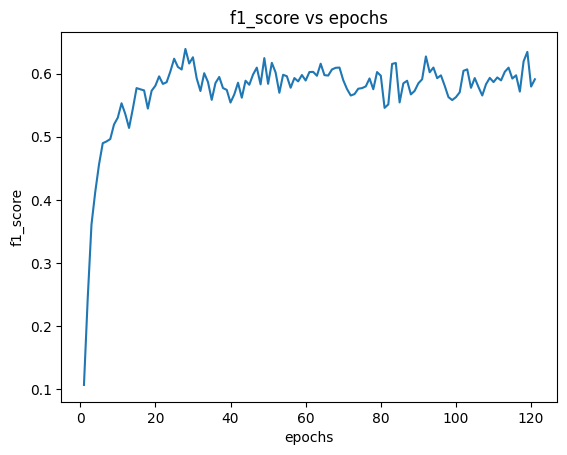

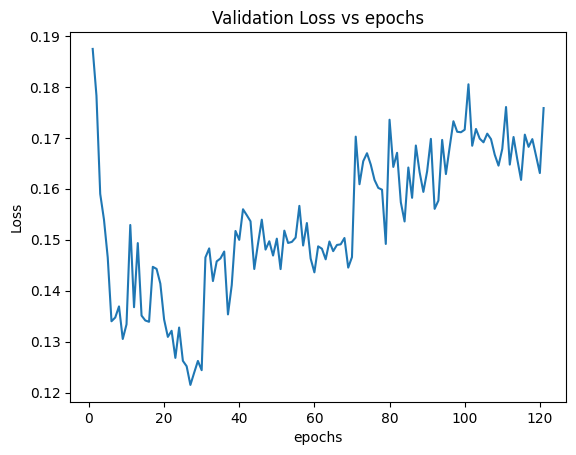

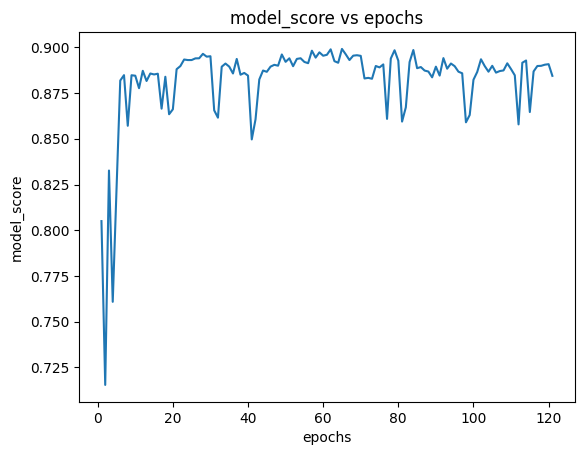

In [7]:
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,122), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,122), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,122), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

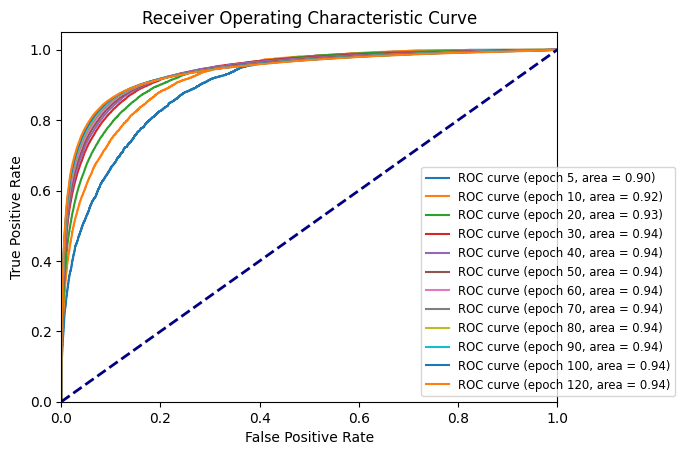

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)